In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from scipy import stats

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#### 데이터 불러오기

In [3]:
train = pd.read_csv('train_변수명수정결측치0.csv', encoding='cp949')
train.head()

,Unnamed: 0,stn,year,mmddhh,ta,td,hm,ws,rn,re,...,ss,sn,month,day,hour,spring,summer,autumn,winter,season
0,1,1,A,20100,-9.9,-10.7,93.9,0.6,0.0,0.0,...,0.0,0.0,2,1,0,0,0,0,1,4
1,2,1,A,20101,-10.8,-11.6,93.8,0.6,0.0,0.0,...,0.0,0.0,2,1,1,0,0,0,1,4
2,3,1,A,20102,-11.4,-12.1,94.6,0.7,0.0,0.0,...,0.0,0.0,2,1,2,0,0,0,1,4
3,4,1,A,20103,-11.6,-12.5,93.4,0.6,0.0,0.0,...,0.0,0.0,2,1,3,0,0,0,1,4
4,5,1,A,20104,-11.8,-12.7,93.0,0.6,0.0,0.0,...,0.0,0.0,2,1,4,0,0,0,1,4


In [4]:
# 결측 개수 확인
train.isnull().sum()

Unnamed: 0       0
stn              0
year             0
mmddhh           0
ta              63
td              78
hm              17
ws             429
rn            7140
re            1573
ww               0
ts               0
si               0
ss               0
sn               0
month            0
day              0
hour             0
spring           0
summer           0
autumn           0
winter           0
season           0
dtype: int64

#### 변수변환: year(A~F => 2016~2021)

In [5]:
train_copy = train.copy()
train_copy['year_num'] = train_copy.year.apply(lambda x: 2016 if x == 'A' 
                                            else 2017 if x == 'B'
                                            else 2018 if x == 'C'
                                            else 2019 if x == 'D'
                                            else 2020 if x == 'E'
                                            else 2021 if x == 'F'
                                            else x)

In [6]:
# 공지사항: 값 수정해야 함
qq = train[(train['rn']==1.8)|(train['rn']==3.3)|
                (train['rn']==5.3)|(train['rn']==19.5)|
                (train['rn']==30.3)|(train['rn']==623.5)].copy()

# 변경해야 할 값이 579개인 것을 확인
print(f"변경 할 rn결측치 값:{len(qq)}")
print(f"변경 전 rn결측치 개수:{train.rn.isnull().sum()}")

train_copy['rn'] = train_copy.rn.apply(lambda x: np.nan if (x == 1.8)|(x ==3.3)
                                       |(x==5.3)|(x==19.5)|(x==30.3)|(x==623.5)  
                                        else x)

# rn 결측치 579개 추가됨
print(f'변경 후 rn결측치 개수:{train_copy["rn"].isnull().sum()}')
print(f"변경 전후 개수 차이:{train_copy['rn'].isnull().sum() - train['rn'].isnull().sum()}")

변경 할 rn결측치 값:579
변경 전 rn결측치 개수:7140
변경 후 rn결측치 개수:7719
변경 전후 개수 차이:579


In [7]:
train_copy[['year_num', 'year']].value_counts()

year_num  year
2019      D       87746
2017      B       87498
2020      E       87497
2018      C       87390
2016      A       80043
2021      F        7439
Name: count, dtype: int64

In [8]:
train_copy.drop(['Unnamed: 0'], axis=1, inplace=True)
train_copy.columns

Index(['stn', 'year', 'mmddhh', 'ta', 'td', 'hm', 'ws', 'rn', 're', 'ww', 'ts',
       'si', 'ss', 'sn', 'month', 'day', 'hour', 'spring', 'summer', 'autumn',
       'winter', 'season', 'year_num'],
      dtype='object')

##### 변수생성: yyyymmddhh형식

In [9]:
# Create 'ymd' column
train_copy['ymd'] = (train_copy['year_num'].astype(str) + '-' + train_copy['month'].astype(str).str.zfill(2)
                     + '-' + train_copy['day'].astype(str).str.zfill(2))
print(train_copy.ymd)

# Create 'ymdh' column
train_copy['ymdh'] = (train_copy['year_num'].astype(str) + '-' + train_copy['month'].astype(str).str.zfill(2)
                      + '-' + train_copy['day'].astype(str).str.zfill(2)
                      + '-' + train_copy['hour'].astype(str).str.zfill(2))
print(train_copy.ymdh)

# Convert 'ymdh' column to datetime
train_copy['ymdh'] = pd.to_datetime(train_copy['ymdh'], errors='coerce')
print(train_copy.ymdh)

0         2016-02-01
1         2016-02-01
2         2016-02-01
3         2016-02-01
4         2016-02-01
             ...    
437608    2021-01-31
437609    2021-01-31
437610    2021-01-31
437611    2021-01-31
437612    2021-01-31
Name: ymd, Length: 437613, dtype: object
0         2016-02-01-00
1         2016-02-01-01
2         2016-02-01-02
3         2016-02-01-03
4         2016-02-01-04
              ...      
437608    2021-01-31-19
437609    2021-01-31-20
437610    2021-01-31-21
437611    2021-01-31-22
437612    2021-01-31-23
Name: ymdh, Length: 437613, dtype: object
0        2016-02-01 00:00:00
1        2016-02-01 01:00:00
2        2016-02-01 02:00:00
3        2016-02-01 03:00:00
4        2016-02-01 04:00:00
                 ...        
437608   2021-01-31 19:00:00
437609   2021-01-31 20:00:00
437610   2021-01-31 21:00:00
437611   2021-01-31 22:00:00
437612   2021-01-31 23:00:00
Name: ymdh, Length: 437613, dtype: datetime64[ns]


In [10]:
print(train_copy.isnull().sum())

stn            0
year           0
mmddhh         0
ta            63
td            78
hm            17
ws           429
rn          7719
re          1573
ww             0
ts             0
si             0
ss             0
sn             0
month          0
day            0
hour           0
spring         0
summer         0
autumn         0
winter         0
season         0
year_num       0
ymd            0
ymdh         240
dtype: int64


###### ymdh만드는 과정에서 결측치 생성
<p style="font-size: 15px"> Year: D에만 윤달 존재다른 년도에는 윤달이 존재하지 않아, 일(Day)별 평균, 최저, 최고 온도를 계산할 때 결측치 생성 
<p style="font-size: 15px"> 윤달 제거, 240개 행 </p>

In [11]:
train_copy[train_copy['ymdh'].isnull()].head()

,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,...,day,hour,spring,summer,autumn,winter,season,year_num,ymd,ymdh
26912,1,D,22900,3.6,2.8,94.4,0.6,0.0,0.0,H,...,29,0,0,0,0,1,4,2019,2019-02-29,NaT
26913,1,D,22901,3.7,2.7,93.0,1.4,0.0,0.0,H,...,29,1,0,0,0,1,4,2019,2019-02-29,NaT
26914,1,D,22902,3.8,2.4,91.0,0.6,0.0,0.0,H,...,29,2,0,0,0,1,4,2019,2019-02-29,NaT
26915,1,D,22903,3.8,2.7,92.6,0.7,0.0,0.0,H,...,29,3,0,0,0,1,4,2019,2019-02-29,NaT
26916,1,D,22904,3.8,2.9,94.0,0.2,0.0,0.0,H,...,29,4,0,0,0,1,4,2019,2019-02-29,NaT


In [12]:
# 윤달 Year:D 2월 29일 240개 행 제거
# 각 stn(1~10) x 하루 24개 행: 240개
train_copy.drop(train_copy[(train_copy['month']==2)&(train_copy['day']==29)].index, inplace=True)
print(f"윤달 제거 전후 행 차이:{len(train) - len(train_copy)}")
train_copy[train_copy['ymdh'].isnull()].head()

윤달 제거 전후 행 차이:240


,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,...,day,hour,spring,summer,autumn,winter,season,year_num,ymd,ymdh


##### 일별 최고, 최저, 평균 값 출력

In [13]:
daily_stats = train_copy.groupby(train_copy['ymdh'].dt.date)['ta'].agg(['mean', 'min', 'max'])
print(daily_stats)
daily_stats.info()

                mean   min   max
ymdh                            
2016-02-01 -1.207917 -12.0   7.8
2016-02-02 -0.721250 -14.2   9.8
2016-02-03  2.480000  -9.1  12.2
2016-02-04  3.807531  -7.4  14.8
2016-02-05  4.317917  -0.6  11.7
...              ...   ...   ...
2021-01-27  1.555000  -7.8  11.2
2021-01-28 -0.019583 -10.6   9.3
2021-01-29 -0.899167 -11.5   7.3
2021-01-30 -0.985417 -12.5   8.7
2021-01-31  0.165833 -12.5   9.6

[1825 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 2016-02-01 to 2021-01-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    1825 non-null   float64
 1   min     1825 non-null   float64
 2   max     1825 non-null   float64
dtypes: float64(3)
memory usage: 57.0+ KB


##### 월별 최저, 최고, 평균 그래프 그리기
- 변곡점 8월
- ts 결측치 처리 후 plot

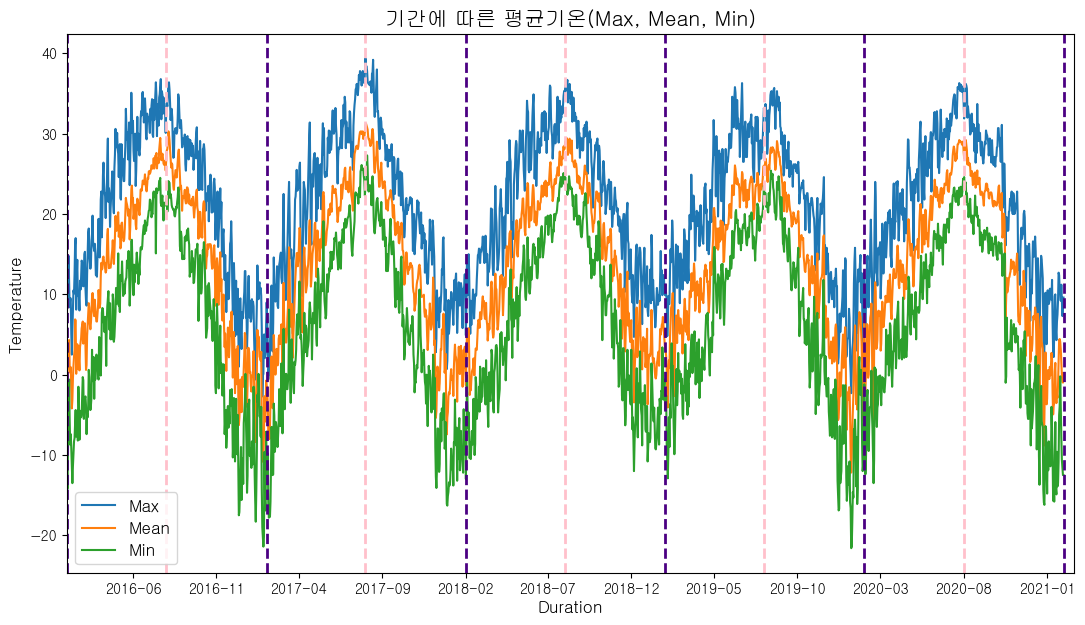

In [14]:
plt.figure(figsize=(13,7))
plt.title('기간에 따른 평균기온(Max, Mean, Min)',fontsize=15)
plt.plot(daily_stats.index, daily_stats['max'], label='Max')
plt.plot(daily_stats.index, daily_stats['mean'], label='Mean')
plt.plot(daily_stats.index, daily_stats['min'], label='Min')
plt.xlabel('Duration', fontsize=12)
plt.xticks()
plt.ylabel('Temperature', fontsize=12)
plt.legend(fontsize=12)

# Set x-axis ticks to be monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlim(daily_stats.index.min(), pd.Timestamp(year=2021, month=2, day=20))
for year in range(daily_stats.index.min().year, daily_stats.index.max().year + 1):
    plt.axvline(x=pd.Timestamp(year=year, month=8, day=1), color='pink', linestyle='--', linewidth=2)
    plt.axvline(x=pd.Timestamp(year=year, month=2, day=1), color='indigo', linestyle='--', linewidth=2)

plt.show()

##### 평균 지면 온도 Q1, Q3로 나눠서 3분할 해보기

###### 평균 지면 온도 Q1, Q3 구하기
- Q1:5.910833, Q3: 22.239167

In [16]:
print(f"Q1: {round(daily_stats['mean'].quantile(0.25),6)}")
print(f"Q3: {round(daily_stats['mean'].quantile(0.75),6)}")

Q1: 5.910833
Q3: 22.239167


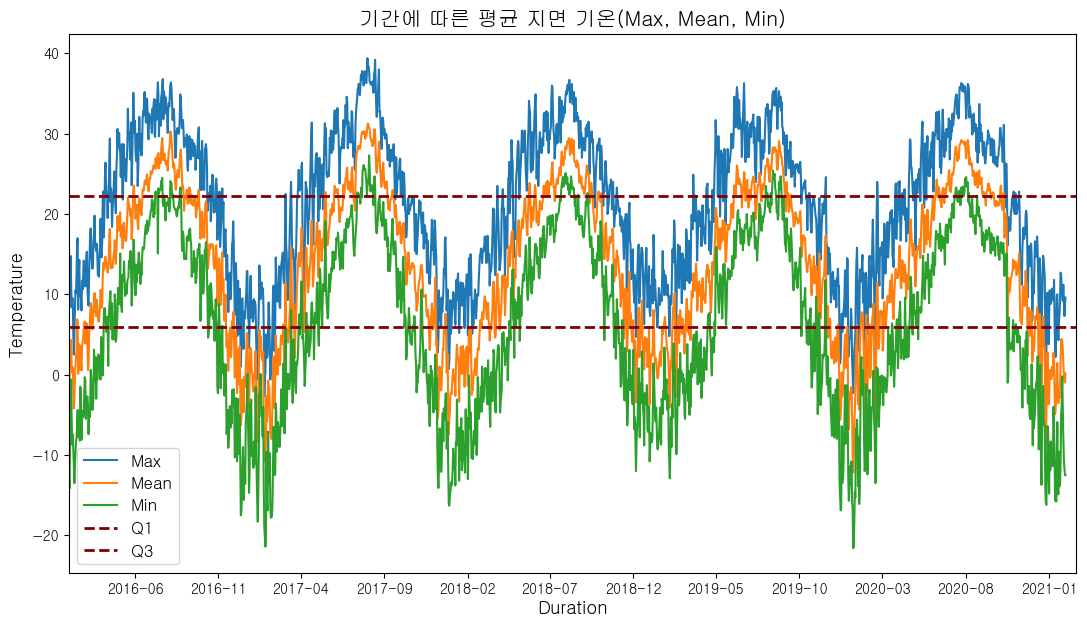

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# low, middle, high의 평균 및 95% 신뢰구간 추가하기

plt.figure(figsize=(13, 7))
plt.title('기간에 따른 평균 지면 기온(Max, Mean, Min)', fontsize=15)
plt.plot(daily_stats.index, daily_stats['max'], label='Max')
plt.plot(daily_stats.index, daily_stats['mean'], label='Mean')
plt.plot(daily_stats.index, daily_stats['min'], label='Min')
plt.xlabel('Duration', fontsize=13)
plt.xticks()
plt.ylabel('Temperature', fontsize=13)
plt.legend()

# Set x-axis ticks to be monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlim(daily_stats.index.min(), pd.Timestamp(year=2021, month=2, day=20))

# Add horizontal lines for Q1 and Q3
plt.axhline(y=5.910833, color='maroon', linestyle='--', linewidth=2,label='Q1')
plt.axhline(y=22.239167, color='maroon', linestyle='--', linewidth=2,label='Q3')

plt.legend(fontsize=12)
plt.show()

In [18]:
ds = daily_stats.copy()
ds['yy'] = ds.index
print('평균 기온 Q1 ~ Q3 결과')
a = ds[(ds['mean']>=5.910833)&(ds['mean']<=22.239167)]
a.loc[:, 'yy'] = a['yy'].astype(str)
print(train_copy[train_copy['ymd'].isin(a['yy'])].shape)
print(train_copy[train_copy['ymd'].isin(a['yy'])].index[:5])
print('\t')
print('평균 기온 > Q3 결과')
b = ds[(ds['mean']>22.239167)]
b.loc[:, 'yy'] = b['yy'].astype(str)
print(train_copy[train_copy['ymd'].isin(b['yy'])].shape)
print(train_copy[train_copy['ymd'].isin(b['yy'])].index[:5])
print('\t')
print('평균 기온 < Q1 결과')
d = ds[(ds['mean']<5.910833)]
d.loc[:, 'yy'] = d['yy'].astype(str)
print(train_copy[train_copy['ymd'].isin(d['yy'])].shape)
print(train_copy[train_copy['ymd'].isin(d['yy'])].index[:5])

평균 기온 Q1 ~ Q3 결과
(218769, 25)
Index([360, 361, 362, 363, 364], dtype='int64')
	
평균 기온 > Q3 결과
(109256, 25)
Index([2806, 2807, 2808, 2809, 2810], dtype='int64')
	
평균 기온 < Q1 결과
(109348, 25)
Index([0, 1, 2, 3, 4], dtype='int64')


In [45]:
middle = train_copy[train_copy['ymd'].isin(a['yy'])].copy()
print(middle.month.unique())

high = train_copy[train_copy['ymd'].isin(b['yy'])].copy()
print(high.month.unique())

low = train_copy[train_copy['ymd'].isin(d['yy'])].copy()
print(low.month.unique())

[ 2  3  4  5  6  8  9 10 11  7 12  1]
[ 5  6  7  8  9 10]
[ 2  3 11 12  1  4]


##### 결측치 채우기

In [49]:
# 하루 나누기
train_copy['day_split'] = train_copy.hour.apply(lambda x: '새벽' if 0 <= x <= 5 
                                                     else '아침' if 6 <= x <=11 
                                                     else '낮' if 12 <= x <= 16
                                                     else '저녁' if 17 <= x <= 20
                                                     else '밤' if 21 <= x <= 23
                                                     else x)

print(train_copy.day_split.value_counts())

day_split
새벽    109413
아침    109341
낮      91012
저녁     72905
밤      54702
Name: count, dtype: int64


In [ ]:
# 일별 오전, 오후, 밤을 이용하여 결측치 채우기
train_copy['ta'] = train_copy['ta'].fillna(train_copy.groupby([])['ta'].transform('mean'))